In [1]:
import numpy as np

In [2]:
# method from:
# https://towardsdatascience.com/fast-fourier-transform-937926e591cb
def dft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

In [3]:
# method from:
# https://towardsdatascience.com/fast-fourier-transform-937926e591cb
def fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return dft(x)
    else:
        X_even = fft(x[::2])
        X_odd = fft(x[1::2])
        terms = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + terms[:int(N/2)] * X_odd,
                               X_even + terms[int(N/2):] * X_odd])

In [4]:
# adapted method
def discrete_fourier_transform(x):
    # easier to transfer to C/C++
    x = np.asarray(x, dtype=float)
    N = len(x)
    x_result = np.zeros(N, dtype='complex_')
    for k in range(N):
        for n in range(N):
            x_result[k] += x[n]*np.exp(-2j * np.pi * k * n / N)
    return x_result

In [5]:
# adapted method
def fast_fourier_transform(x):
    # easier to transfer to C/C++
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N % 2 > 0:
        raise ValueError("must be a power of 2")
    elif N <= 2:
        return discrete_fourier_transform(x)
    else:
        x_result = np.empty(N, dtype='complex_')
        x_even = fast_fourier_transform(x[0::2])
        x_odd = fast_fourier_transform(x[1::2])
        # prob. just a ridiculous micro optimization
        for k in range(0, int(N/2)):
            x_result[k] = x_even[k] + (x_odd[k] * np.exp(-2j * np.pi * k / N))
            # another ridiculous micro optimization
            k2 = int(k + N/2)
            x_result[k2] = x_even[k] + (
                x_odd[k] * np.exp(-2j * np.pi * k2 / N)
            )
        return x_result

make sure every function outputs about the same thing

In [6]:
x = np.random.random(1024)

In [7]:
a = dft(x)
b = discrete_fourier_transform(x)
np.allclose(a, b)

True

In [8]:
c = fft(x)
np.allclose(a, c)

True

In [9]:
d = fast_fourier_transform(x)
np.allclose(a, d)

True

In [10]:
e = np.fft.fft(x)
np.allclose(a, e)

True

benchmarking machine

In [18]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2299.998
BogoMIPS:            4599.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [19]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        588M         10G        984K        1.9G         11G
Swap:            0B          0B          0B


benchmarking 1

In [ ]:
x = np.random.random(1024)

In [13]:
%%timeit -n 10
a = dft(x)

10 loops, best of 5: 123 ms per loop


In [14]:
%%timeit -n 10
b = discrete_fourier_transform(x)

10 loops, best of 5: 4.9 s per loop


In [15]:
%%timeit -n 10
c = fft(x)

10 loops, best of 5: 14.8 ms per loop


In [16]:
%%timeit -n 10
d = fast_fourier_transform(x)

10 loops, best of 5: 36.5 ms per loop


In [17]:
%%timeit -n 10
e = np.fft.fft(x)

10 loops, best of 5: 27.1 µs per loop


benchmarking 2

In [73]:
N = [4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

In [20]:
X = [np.random.random(n) for n in N]

In [27]:
import time

def benchmark(fft_func, X):
    total_time_list = []
    for x in X:
        start_time = time.time()
        y = fft_func(x)
        total_time = time.time() - start_time
        total_time_list.append(total_time)
    return total_time_list

In [64]:
import matplotlib.pyplot as plt
from functools import partial

In [65]:
benchmark = partial(benchmark, X=X)

In [67]:
plot_y_list = []

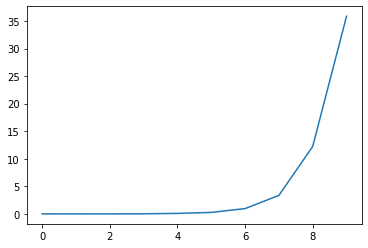

In [68]:
benchmark = partial(benchmark, fft_func=dft)

plot_y = np.array([benchmark() for _ in range(100)]).sum(axis=0)
plot_y_list.append(plot_y)
plot_x = list(range(len(plot_y)))
plt.plot(plot_x, plot_y)
plt.show()

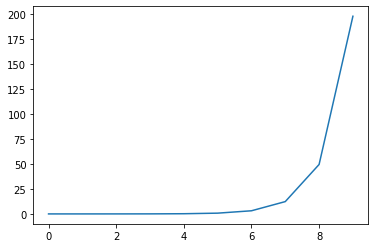

In [69]:
benchmark = partial(benchmark, fft_func=discrete_fourier_transform)

plot_y = np.array([benchmark() for _ in range(10)]).sum(axis=0)
plot_y_list.append(plot_y)
plot_x = list(range(len(plot_y)))
plt.plot(plot_x, plot_y)
plt.show()

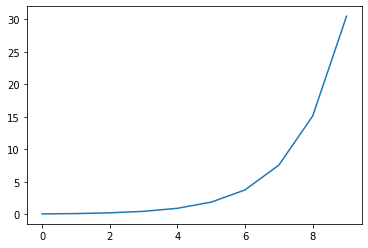

In [70]:
benchmark = partial(benchmark, fft_func=fft)

plot_y = np.array([benchmark() for _ in range(1000)]).sum(axis=0)
plot_y_list.append(plot_y)
plot_x = list(range(len(plot_y)))
plt.plot(plot_x, plot_y)
plt.show()

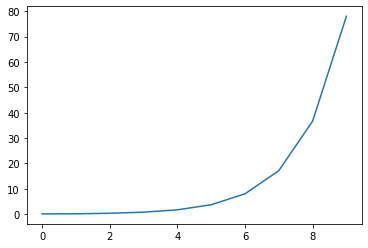

In [71]:
benchmark = partial(benchmark, fft_func=fast_fourier_transform)

plot_y = np.array([benchmark() for _ in range(1000)]).sum(axis=0)
plot_y_list.append(plot_y)
plot_x = list(range(len(plot_y)))
plt.plot(plot_x, plot_y)
plt.show()

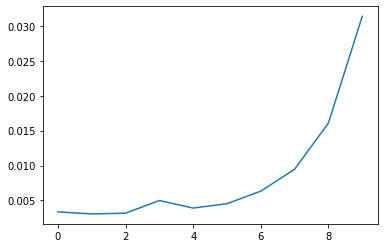

In [72]:
benchmark = partial(benchmark, fft_func=np.fft.fft)

plot_y = np.array([benchmark() for _ in range(1000)]).sum(axis=0)
plot_y_list.append(plot_y)
plot_x = list(range(len(plot_y)))
plt.plot(plot_x, plot_y)
plt.show()

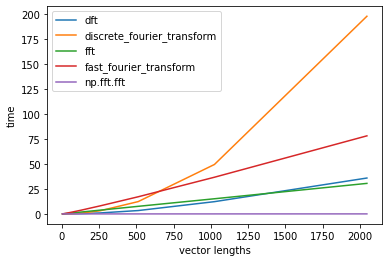

In [74]:
plt.plot(N, plot_y_list[0], label="dft")
plt.plot(N, plot_y_list[1], label="discrete_fourier_transform")
plt.plot(N, plot_y_list[2], label="fft")
plt.plot(N, plot_y_list[3], label="fast_fourier_transform")
plt.plot(N, plot_y_list[4], label="np.fft.fft")
plt.xlabel('vector lengths')
# Set the y axis label of the current axis.
plt.ylabel('time')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()